## 93. BLEUスコアの計測
<p>91で学習したニューラル機械翻訳モデルの品質を調べるため，評価データにおけるBLEUスコアを測定せよ．</p>

In [1]:
from fastai_model import Model, get_param, get_elms
from Chapter10_91 import Translator, DataSet, dataloader
import torch
import pickle
if __name__ == '__main__':
    with open('model_logs/ja_dic.pickle', 'rb') as f: ja_dic = pickle.load(f)
    with open('model_logs/en_dic.pickle', 'rb') as f: en_dic = pickle.load(f)
    ja_dicsize = max(ja_dic.values())+1
    en_dicsize = max(en_dic.values())+1

In [2]:
if __name__ == '__main__':
    for k,v in get_param().items():
        print(f"{k}: {v}")

cuda_optim: False
n_layers: 6
n_heads: 8
d_model: 256
d_head: 32
d_inner: 1024
drop: 0.1
bias: True
scale: True
double_drop: True
lrate_coef: 1
warmup_steps: 4000


In [3]:
if __name__ == '__main__':
    params = get_param(d_model=512)
    model, optimizer, scheduler, device = get_elms(params, 'cuda:9', ja_dicsize, en_dicsize)
    model.load_state_dict(torch.load("model_logs/fastai_20200804_140519/18_save.t7", map_location=lambda storage, loc: storage))

cuda:9
44611280


In [4]:
if __name__ == '__main__':
    devset = DataSet("dev")
    testset = DataSet("test")
    translator = Translator(ja_dic, en_dic)

In [5]:
from tqdm import tqdm
import torch
from Chapter10_91 import forceSacrebleuScorer

def bleu_score(model, dataset, translator, func, device=torch.device('cpu'), beam=1, total=None):
    sacrebleu = forceSacrebleuScorer()
    loader = dataloader(dataset, batch_size=1, device=device, shuffle=True)
    model.to(device)
    total = total if total else len(loader)-1
    with tqdm(enumerate(loader), total=total, desc=f"beam={beam:>3}") as t:
        for step,(ja,en,en_ans) in t:
            ja, en, en_ans = ja[0], en[0], en_ans[0].tolist()
            pred = translator.translate_j2e_seq(model, ja, length=len(en), device=device, stop=True, beam=beam)[0][0]
            sacrebleu.add_string(ref=func(en_ans[:-1]), pred=func(pred[:-1]+([] if pred[-1]==11 else [pred[-1]])))
            if step == total:
                score = sacrebleu.score()
                t.postfix = f"beam={beam}\t: bleu:{score:.8f}"
                t.update()
                return score, sacrebleu.result_string().format()

In [6]:
if __name__ == '__main__':
    from string import ascii_letters
    from random import choices
    func = lambda seq: " ".join([translator.en_dic_rev[s] if s!=12 else ''.join(choices(ascii_letters,k=5)) for s in seq])
    score, string = bleu_score(model, devset, translator, func, device=device)
    print(f"bleu:{score:.8f}, {string}")

beam=  1: 100%|██████████| 1165/1165 [04:06<00:00,  4.73it/s, beam=1	: bleu:12.99745547]

bleu:12.99745547, BLEU = 13.00 44.9/19.2/9.6/5.2 (BP = 0.903 ratio = 0.907 hyp_len = 22639 ref_len = 24953)


## 94. ビーム探索
<p>91で学習したニューラル機械翻訳モデルで翻訳文をデコードする際に，ビーム探索を導入せよ．ビーム幅を1から100くらいまで適当に変化させながら，開発セット上のBLEUスコアの変化をプロットせよ．</p>

### beam search was implemented at 
[./Chapter10_91.ipynb](Chapter10_91.ipynb)

In [9]:
if __name__ == '__main__':
    import matplotlib.pyplot as plt
    bleus = {}
    func = lambda seq: " ".join([translator.en_dic_rev[s] if s!=12 else ''.join(choices(ascii_letters,k=5)) for s in seq])

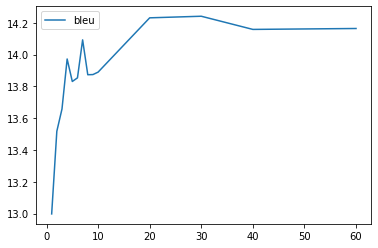

In [18]:
if __name__ == '__main__':
    for i in list(range(1,10))+[10,20,30,40,60]:
        if i in bleus.keys(): continue
        bleus[i] = bleu_score(model, devset, translator, func, device=device, beam=i)
    plt.plot(list(bleus.keys()), list(map(lambda x:x[0], bleus.values())), label="bleu")
    plt.legend()

In [19]:
if __name__ == '__main__':
    bleus

{1: (12.997455471988497,
  'BLEU = 13.00 44.9/19.2/9.6/5.2 (BP = 0.903 ratio = 0.907 hyp_len = 22639 ref_len = 24953)'),
 2: (13.517700851201953,
  'BLEU = 13.52 46.3/20.2/10.3/5.4 (BP = 0.897 ratio = 0.902 hyp_len = 22512 ref_len = 24953)'),
 3: (13.657914758702722,
  'BLEU = 13.66 46.7/20.7/10.4/5.5 (BP = 0.893 ratio = 0.898 hyp_len = 22409 ref_len = 24953)'),
 4: (13.972630602741944,
  'BLEU = 13.97 47.1/21.1/10.7/5.7 (BP = 0.892 ratio = 0.898 hyp_len = 22400 ref_len = 24953)'),
 5: (13.831063695359758,
  'BLEU = 13.83 47.0/20.9/10.6/5.6 (BP = 0.888 ratio = 0.894 hyp_len = 22307 ref_len = 24953)'),
 6: (13.853889830690191,
  'BLEU = 13.85 47.0/20.9/10.7/5.6 (BP = 0.888 ratio = 0.894 hyp_len = 22310 ref_len = 24953)'),
 7: (14.093023960240476,
  'BLEU = 14.09 47.4/21.3/10.9/5.8 (BP = 0.886 ratio = 0.892 hyp_len = 22268 ref_len = 24953)'),
 8: (13.873522344847736,
  'BLEU = 13.87 47.3/21.2/10.7/5.7 (BP = 0.883 ratio = 0.889 hyp_len = 22189 ref_len = 24953)'),
 9: (13.87461167230344,
 

In [20]:
if __name__ == '__main__':
    !jupyter nbconvert --to python Chapter10_93and94.ipynb

[NbConvertApp] Converting notebook Chapter10_93and94.ipynb to python
[NbConvertApp] Writing 3328 bytes to Chapter10_93and94.py
